# Deep Deterministic Policy Gradient (DDPG)

**Author:** [amifunny](https://github.com/amifunny)<br>
**Date created:** 2020/06/04<br>
**Last modified:** 2020/09/21<br>
**Description:** Implementing DDPG algorithm on the Inverted Pendulum Problem.

## Introduction

**Deep Deterministic Policy Gradient (DDPG)** is a model-free off-policy algorithm for
learning continous actions.

It combines ideas from DPG (Deterministic Policy Gradient) and DQN (Deep Q-Network).
It uses Experience Replay and slow-learning target networks from DQN, and it is based on
DPG,
which can operate over continuous action spaces.

This tutorial closely follow this paper -
[Continuous control with deep reinforcement learning](https://arxiv.org/pdf/1509.02971.pdf)

## Problem

We are trying to solve the classic **Inverted Pendulum** control problem.
In this setting, we can take only two actions: swing left or swing right.

What make this problem challenging for Q-Learning Algorithms is that actions
are **continuous** instead of being **discrete**. That is, instead of using two
discrete actions like `-1` or `+1`, we have to select from infinite actions
ranging from `-2` to `+2`.

## Quick theory

Just like the Actor-Critic method, we have two networks:

1. Actor - It proposes an action given a state.
2. Critic - It predicts if the action is good (positive value) or bad (negative value)
given a state and an action.

DDPG uses two more techniques not present in the original DQN:

**First, it uses two Target networks.**

**Why?** Because it add stability to training. In short, we are learning from estimated
targets and Target networks are updated slowly, hence keeping our estimated targets
stable.

Conceptually, this is like saying, "I have an idea of how to play this well,
I'm going to try it out for a bit until I find something better",
as opposed to saying "I'm going to re-learn how to play this entire game after every
move".
See this [StackOverflow answer](https://stackoverflow.com/a/54238556/13475679).

**Second, it uses Experience Replay.**

We store list of tuples `(state, action, reward, next_state)`, and instead of
learning only from recent experience, we learn from sampling all of our experience
accumulated so far.

Now, let's see how is it implemented.

To allow this .ipynb file to run on your local machine, gymnasium should be installed because the old gym by openai is deprecated.

In [ ]:
pip install gymnasium

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 925.5/925.5 kB 52.5 MB/s eta 0:00:00


In [ ]:
import gymnasium as gym
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt

We use [OpenAIGym](http://gym.openai.com/docs) to create the environment.
We will use the `upper_bound` parameter to scale our actions later.

In [ ]:
problem = "Pendulum-v1"
env = gym.make(problem)

num_states = env.observation_space.shape[0]
print("Size of State Space ->  {}".format(num_states))
num_actions = env.action_space.shape[0]
print("Size of Action Space ->  {}".format(num_actions))

upper_bound = env.action_space.high[0]
lower_bound = env.action_space.low[0]

print("Max Value of Action ->  {}".format(upper_bound))
print("Min Value of Action ->  {}".format(lower_bound))

Size of State Space ->  3
Size of Action Space ->  1
Max Value of Action ->  2.0
Min Value of Action ->  -2.0


The `Buffer` class implements Experience Replay.

---
![Algorithm](https://i.imgur.com/mS6iGyJ.jpg)
---


**Critic loss** - Mean Squared Error of `y - Q(s, a)`
where `y` is the expected return as seen by the Target network,
and `Q(s, a)` is action value predicted by the Critic network. `y` is a moving target
that the critic model tries to achieve; we make this target
stable by updating the Target model slowly.

**Actor loss** - This is computed using the mean of the value given by the Critic network
for the actions taken by the Actor network. We seek to maximize this quantity.

Hence we update the Actor network so that it produces actions that get
the maximum predicted value as seen by the Critic, for a given state.

In [ ]:
class Buffer:
    def __init__(self, buffer_capacity=100000, batch_size=64):
        # Number of "experiences" to store at max
        self.buffer_capacity = buffer_capacity
        # Num of tuples to train on.
        self.batch_size = batch_size

        # Its tells us num of times record() was called.
        self.buffer_counter = 0

        # Instead of list of tuples as the exp.replay concept go
        # We use different np.arrays for each tuple element
        self.state_buffer = np.zeros((self.buffer_capacity, num_states))
        self.action_buffer = np.zeros((self.buffer_capacity, num_actions))
        self.reward_buffer = np.zeros((self.buffer_capacity, 1))
        self.next_state_buffer = np.zeros((self.buffer_capacity, num_states))

    # Takes (s,a,r,s') obervation tuple as input
    def record(self, obs_tuple):
        # Set index to zero if buffer_capacity is exceeded,
        # replacing old records
        index = self.buffer_counter % self.buffer_capacity

        self.state_buffer[index] = obs_tuple[0]
        self.action_buffer[index] = obs_tuple[1]
        self.reward_buffer[index] = obs_tuple[2]
        self.next_state_buffer[index] = obs_tuple[3]

        self.buffer_counter += 1

    # Eager execution is turned on by default in TensorFlow 2. Decorating with tf.function allows
    # TensorFlow to build a static graph out of the logic and computations in our function.
    # This provides a large speed up for blocks of code that contain many small TensorFlow operations such as this one.
    @tf.function
    def update(
        self, state_batch, action_batch, reward_batch, next_state_batch,
    ):
        # Training and updating Actor & Critic networks.
        # See Pseudo Code.
        with tf.GradientTape() as tape:
            target_actions = target_actor(next_state_batch, training=True)
            ##############################################################################
            #   TODO: Enter the suitable contents of the critic loss     #
            #     hint: the target output of the critic model is      #
            #         as follows:                       #
            #           y = reward_batch + gamma * target_critic    #
            ##############################################################################
            y = None + None * target_critic([next_state_batch, target_actions], training=True)

            critic_value = critic_model([state_batch, action_batch], training=True)
            critic_loss = tf.math.reduce_mean(tf.math.square(y - critic_value))

        critic_grad = tape.gradient(critic_loss, critic_model.trainable_variables)
        critic_optimizer.apply_gradients(
            zip(critic_grad, critic_model.trainable_variables)
        )

        with tf.GradientTape() as tape:
            actions = actor_model(state_batch, training=True)
            critic_value = critic_model([state_batch, actions], training=True)
            # Used `-value` as we want to maximize the value given
            # by the critic for our actions
            actor_loss = -tf.math.reduce_mean(critic_value)

        actor_grad = tape.gradient(actor_loss, actor_model.trainable_variables)
        actor_optimizer.apply_gradients(
            zip(actor_grad, actor_model.trainable_variables)
        )

    # We compute the loss and update parameters
    def learn(self):
        # Get sampling range
        record_range = min(self.buffer_counter, self.buffer_capacity)
        # Randomly sample indices
        batch_indices = np.random.choice(record_range, self.batch_size)

        # Convert to tensors
        state_batch = tf.convert_to_tensor(self.state_buffer[batch_indices])
        action_batch = tf.convert_to_tensor(self.action_buffer[batch_indices])
        reward_batch = tf.convert_to_tensor(self.reward_buffer[batch_indices])
        reward_batch = tf.cast(reward_batch, dtype=tf.float32)
        next_state_batch = tf.convert_to_tensor(self.next_state_buffer[batch_indices])

        self.update(state_batch, action_batch, reward_batch, next_state_batch)


# This update target parameters slowly
# Based on rate `tau`, which is much less than one.
@tf.function
def update_target(target_weights, weights, tau):
    for (a, b) in zip(target_weights, weights):
        a.assign(b * tau + a * (1 - tau))


Here we define the Actor and Critic networks. These are basic Dense models
with `ReLU` activation.

Note: We need the initialization for last layer of the Actor to be between
`-0.003` and `0.003` as this prevents us from getting `1` or `-1` output values in
the initial stages, which would squash our gradients to zero,
as we use the `tanh` activation.

In [ ]:
def get_actor():
    # Initialize weights between -3e-3 and 3-e3
    last_init = tf.random_uniform_initializer(minval=-0.003, maxval=0.003)

    inputs = layers.Input(shape=(num_states,))
    out = layers.Dense(256, activation="relu")(inputs)
    ##############################################################################
    #  TODO: add three more Dense layers to the actor model     #
    #      so that the final model has four total layers     #
    # hint: out = layers.Dense(output_dimension, activation="relu")(out)  #
    ##############################################################################
    pass
    ##############################################################################
    #                   END                 #
    ##############################################################################

    ##############################################################################
    #   TODO: Enter the output dimension of the actor model     #
    #   hint: the output of the actor model should be the action  #
    ##############################################################################
    outputs = layers.Dense(None, activation="tanh", kernel_initializer=last_init)(out)

    # Our upper bound is 2.0 for Pendulum.
    outputs = outputs * upper_bound
    model = tf.keras.Model(inputs, outputs)
    return model


def get_critic():
    ##############################################################################
    #   TODO: Enter the input dimension of the critic model     #
    #   hint: there should be two different inputs, the state and #
    #       the action                         #
    ##############################################################################
    # State as input
    state_input = layers.Input(shape=(None))
    state_out = layers.Dense(16, activation="relu")(state_input)
    state_out = layers.Dense(32, activation="relu")(state_out)

    # Action as input
    action_input = layers.Input(shape=(None))
    action_out = layers.Dense(32, activation="relu")(action_input)

    # Both are passed through seperate layer before concatenating
    concat = layers.Concatenate()([state_out, action_out])

    out = layers.Dense(256, activation="relu")(concat)
    out = layers.Dense(256, activation="relu")(out)
    outputs = layers.Dense(1)(out)

    # Outputs single value for give state-action
    model = tf.keras.Model([state_input, action_input], outputs)

    return model


`policy()` returns an action sampled from our Actor network plus some noise for
exploration.

In [ ]:
def policy(state, rand_mean=0, rand_std=0.1):
    sampled_actions = tf.squeeze(actor_model(state))

    # Adding noise to action
    sampled_actions = sampled_actions.numpy() + np.random.normal(rand_mean, rand_std)

    # We make sure action is within bounds
    legal_action = np.clip(sampled_actions, lower_bound, upper_bound)

    return [np.squeeze(legal_action)]


## Training hyperparameters

In [ ]:
std_dev = 0.2

actor_model = get_actor()
critic_model = get_critic()

target_actor = get_actor()
target_critic = get_critic()

# Making the weights equal initially
target_actor.set_weights(actor_model.get_weights())
target_critic.set_weights(critic_model.get_weights())

##########################################################################
#     TODO: Implement suitable learning rates         #
#          too low -> slow convergance          #
#          too high -> hard to converge         #
#           hint:critic_lr = 0.001            #
#              actor_lr = 0.001             #
##########################################################################
# Learning rate for actor-critic models
critic_lr = None
actor_lr = None

critic_optimizer = tf.keras.optimizers.Adam(critic_lr)
actor_optimizer = tf.keras.optimizers.Adam(actor_lr)


##########################################################################
#     TODO: Implement suitable number of total episode    #
#          too low -> unable convergance         #
#          too high -> spend too much time       #
#           hint:total_episodes = 100           #
##########################################################################
total_episodes = None

##########################################################################
#     TODO: Implement suitable discount factor        #
#     low -> depend too little on future rewards      #
#     high -> depend too much on future rewards      #
#           hint:gamma = 0.99               #
##########################################################################
# Discount factor for future rewards
gamma = None

##########################################################################
#     TODO: Implement suitable tau               #
#     low -> the target network updates too slow      #
#     high -> the target network updates too fast     #
#           hint:tau = 0.005               #
##########################################################################
# Used to update target networks
tau = None

##########################################################################
#       TODO: Implement suitable batch size         #
#         effects overall training time          #
#         hint:buffer = Buffer(50000, 64)         #
##########################################################################
# Instantiate a Buffer class
buffer = Buffer(50000, None)

Now we implement our main training loop, and iterate over episodes.
We sample actions using `policy()` and train with `learn()` at each time step,
along with updating the Target networks at a rate `tau`.

Episode * 0 * Avg Reward is ==> -1160.6416971291665
Episode * 1 * Avg Reward is ==> -1209.886511287005
Episode * 2 * Avg Reward is ==> -1271.0199071066095
Episode * 3 * Avg Reward is ==> -1326.258182607917
Episode * 4 * Avg Reward is ==> -1370.0184272423223
Episode * 5 * Avg Reward is ==> -1387.9953745929467
Episode * 6 * Avg Reward is ==> -1402.6459284541836
Episode * 7 * Avg Reward is ==> -1410.9491445587244
Episode * 8 * Avg Reward is ==> -1417.6450958808648
Episode * 9 * Avg Reward is ==> -1385.66642688944
Episode * 10 * Avg Reward is ==> -1360.1809343842763
Episode * 11 * Avg Reward is ==> -1323.4187787446463
Episode * 12 * Avg Reward is ==> -1282.547605052094
Episode * 13 * Avg Reward is ==> -1237.5661196665974
Episode * 14 * Avg Reward is ==> -1155.5328317873166
Episode * 15 * Avg Reward is ==> -1099.6821824243475
Episode * 16 * Avg Reward is ==> -1050.1700835511856
Episode * 17 * Avg Reward is ==> -1006.9438078813879
Episode * 18 * Avg Reward is ==> -967.3152729498987
Episode *

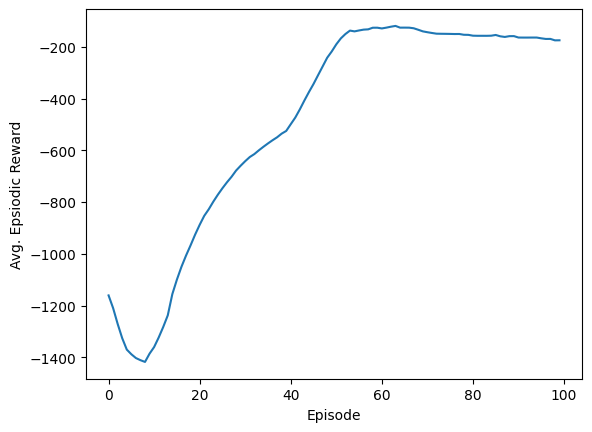

In [ ]:
# To store reward history of each episode
ep_reward_list = []
# To store average reward history of last few episodes
avg_reward_list = []

# Takes about 4 min to train
for ep in range(total_episodes):

    prev_state = env.reset()
    episodic_reward = 0
    timestep_count = 0
    while True:
        # Uncomment this to see the Actor in action
        # But not in a python notebook.
        # env.render()
        if type(prev_state) is tuple:
          prev_state = prev_state[0]

        tf_prev_state = tf.expand_dims(tf.convert_to_tensor(prev_state), 0)

        # parameters for randomness
        rand_mean = 0
        rand_std = 0.1

        action = policy(tf_prev_state, rand_mean, rand_std)
        # Recieve state and reward from environment.

        state, reward, done, info, _ = env.step(action)
        timestep_count = timestep_count + 1
        buffer.record((prev_state, action, reward, state))
        episodic_reward += reward

        buffer.learn()
        update_target(target_actor.variables, actor_model.variables, tau)
        update_target(target_critic.variables, critic_model.variables, tau)

        # End this episode when `done` is True
        if done or timestep_count == 200:
            break

        prev_state = state

    ep_reward_list.append(episodic_reward)

    # Mean of last 40 episodes
    avg_reward = np.mean(ep_reward_list[-40:])
    print("Episode * {} * Avg Reward is ==> {}".format(ep, avg_reward))
    avg_reward_list.append(avg_reward)

# Plotting graph
# Episodes versus Avg. Rewards
plt.plot(avg_reward_list)
plt.xlabel("Episode")
plt.ylabel("Avg. Epsiodic Reward")
plt.show()

If training proceeds correctly, the average episodic reward will increase with time.

Feel free to try different learning rates, `tau` values, and architectures for the
Actor and Critic networks.

The Inverted Pendulum problem has low complexity, but DDPG work great on many other
problems.

Save the new model and remember the name of the model.

In [ ]:
# Save the weights
actor_model.save_weights("pendulum_actor.h5")
critic_model.save_weights("pendulum_critic.h5")

target_actor.save_weights("pendulum_target_actor.h5")
target_critic.save_weights("pendulum_target_critic.h5")

# Results Visualization

To visualize what you have trained, run the following cells.

In [ ]:
from matplotlib import animation
import matplotlib.pyplot as plt
from itertools import count
import gymnasium as gym
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import os

Function for saving frames as gif

In [ ]:
def save_frames_as_gif(frames, path='./', filename='gym_animation_4_input.gif'):

    #Mess with this to change frame size
    plt.figure(figsize=(frames[0].shape[1] / 72.0, frames[0].shape[0] / 72.0), dpi=72)

    patch = plt.imshow(frames[0])
    plt.axis('off')

    def animate(i):
        patch.set_data(frames[i])
    anim = animation.FuncAnimation(plt.gcf(), animate, frames = len(frames), interval=50)
    writergif = animation.PillowWriter(fps=60)
    anim.save(path + filename, writer=writergif)

`policy_no_noise()` returns an action sampled from our Actor network. In practice, only the Actor network is used, and there should be no exploration since there is no need for exploration.

In [ ]:
def policy_no_noise(state):
    sampled_actions = tf.squeeze(actor_model(state)).numpy()

    # We make sure action is within bounds
    legal_action = np.clip(sampled_actions, lower_bound, upper_bound)

    return [np.squeeze(legal_action)]


Now we implement our main inference loop, and iterate over episodes. We sample actions using `policy_no_noise()` at each time step. Remember to change the parameter `model_name`.

Finished making episode No 1
Finished making episode No 2


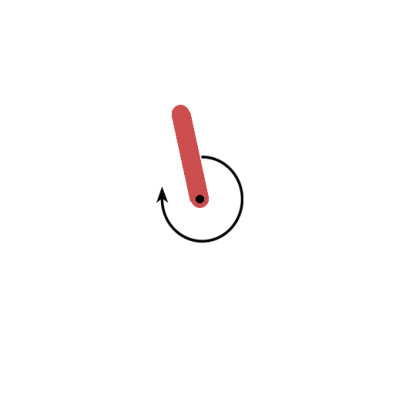

In [ ]:
actor_model = get_actor()

demo_episode = 2
env = gym.make('Pendulum-v1',render_mode="rgb_array")
# env = gym.make('Pendulum-v1',render_mode="human")
try:
  model_name = "pendulum_actor"
  actor_string = "actor"
  model_name.index(actor_string)
except ValueError:
  print("Please use an actor model")
  raise

actor_model = get_actor()
actor_model.load_weights(model_name + ".h5")
frames = []
for i_episode in range(demo_episode):
  # Initialize the environment and get it's state
  state, info = env.reset()
  time_step = 0
  for t in count():
    time_step = time_step + 1
    tf_prev_state = tf.expand_dims(tf.convert_to_tensor(state), 0)
    action = policy_no_noise(tf_prev_state)
    observation, reward, terminated, truncated, _ = env.step(action)
    done = terminated or truncated

    if terminated:
      next_state = None
    else:
      next_state = observation

    # Move to the next state
    state = next_state
    frames.append(env.render())
    if done or time_step > 200:
      print("Finished making episode No", i_episode+1)
      break

env.close()
save_frames_as_gif(frames, filename=model_name+'.gif')



Display the resulting gif file

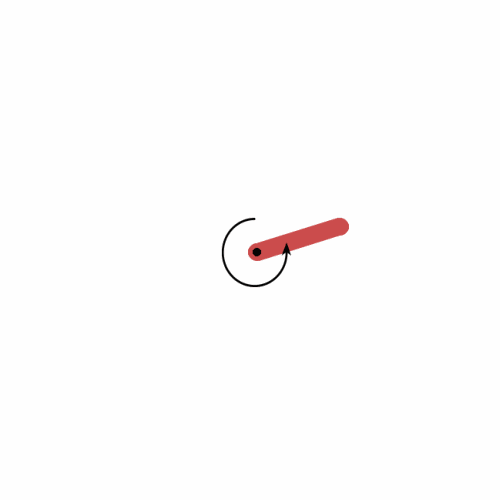

In [ ]:
from IPython.display import Image
display(Image(data=open(model_name+'.gif','rb').read(), format='png'))